## Problem 1

### Model training

In [1]:
import pandas as pd
from indexing import BasicInvertedIndex
import seaborn as sns
import matplotlib.pyplot as plt
import json
import numpy as np
import tqdm
from l2r import L2RFeatureExtractor, L2RRanker
from document_preprocessor import RegexTokenizer
from ranker import BM25, TF_IDF
import gc
from vector_ranker import VectorRanker
from ranker import CrossEncoderScorer
from sentence_transformers import SentenceTransformer, CrossEncoder
import torch
import time
from relevance import run_relevance_tests
from torch.nn.functional import softmax

wiki_path = 'wikipedia_200k_dataset.jsonl'
wiki_title_dir = 'freq_50_cache_title'
wiki_text_dir = 'freq_50_cache'
stop_words_path = 'stopwords.txt'
category_set_path = 'category_set.txt'
doc_category_info_path = 'doc_category_dict.json'
doc_network_path = 'full_network_stats.csv'

temp = json.load(open(doc_category_info_path))
doc_category_info = {}
for key in temp:
    doc_category_info[int(key)] = temp[key]
del temp
gc.collect()

category_set = set()
with open(category_set_path, 'r') as f:
    lines = f.readlines()
    for line in lines:
        category_set.add(line.strip())

stop_words = set()
with open(stop_words_path, 'r', encoding='utf-8') as f:
    lines = f.readlines()
    for line in lines:
        stop_words.add(line.strip())

docid_to_network_features = {}
df = pd.read_csv(doc_network_path)
for row in df.itertuples():
    docid_to_network_features[row.docid] = {'pagerank': row.pagerank, 'authority_score': row.authority_score, 'hub_score': row.hub_score}
      

title_index = BasicInvertedIndex()
title_index.load(wiki_title_dir)
doc_index = BasicInvertedIndex()
doc_index.load(wiki_text_dir)

embedding = np.load('wiki-200k-vecs.msmarco-MiniLM-L12-cos-v5.npy')
docid_path = 'document-ids.txt'
docid_list = []
with open(docid_path, 'r') as f:
    for line in f:
        docid_list.append(int(line.strip()))
vector_ranker = VectorRanker('sentence-transformers/msmarco-MiniLM-L12-cos-v5', embedding, docid_list)

docid_text_map = {}
with open(wiki_path, 'r') as f:
    for line in f:
        doc = json.loads(line)
        docid_text_map[int(doc['docid'])] = ' '.join(doc['text'].split(' ')[:500])
ce_scorer = CrossEncoderScorer(docid_text_map, 'cross-encoder/msmarco-MiniLM-L6-en-de-v1')

d:\Anaconda3\envs\si650\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded!
Loaded!


In [2]:
import l2r
import importlib
importlib.reload(l2r)
from l2r import L2RFeatureExtractor, L2RRanker

l2r_feature_extractor = L2RFeatureExtractor(document_index=doc_index, title_index=title_index, 
                                            doc_category_info=doc_category_info, document_preprocessor=RegexTokenizer('\w+'),
                                            stopwords=stop_words, recognized_categories = category_set,
                                            docid_to_network_features=docid_to_network_features,
                                            ce_scorer=ce_scorer)
vec_ranker = L2RRanker(document_index=doc_index, title_index=title_index, document_preprocessor=RegexTokenizer('\w+'),
                       stopwords=stop_words, ranker=vector_ranker,
                       feature_extractor=l2r_feature_extractor)
bm25_ranker = L2RRanker(document_index=doc_index, title_index=title_index, document_preprocessor=RegexTokenizer('\w+'),
                          stopwords=stop_words, ranker=BM25(doc_index),
                            feature_extractor=l2r_feature_extractor)

In [3]:
vec_ranker.train('training_data/hw2_relevance.train.csv')

Preparing training data
Training data prepared
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005056 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2905
[LightGBM] [Info] Number of data points in the train set: 11916, number of used features: 128


In [10]:
from ranker import Ranker
ranker = Ranker(index=doc_index, document_preprocessor=RegexTokenizer('\w+'), stopwords=stop_words, scorer=BM25(doc_index), raw_text_dict=docid_text_map)
bm25_ranker = L2RRanker(document_index=doc_index, title_index=title_index, document_preprocessor=RegexTokenizer('\w+'),
                          stopwords=stop_words, ranker=ranker,
                            feature_extractor=l2r_feature_extractor)

In [11]:
bm25_ranker.train('training_data/hw2_relevance.train.csv')

Preparing training data
Training data prepared
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004513 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2905
[LightGBM] [Info] Number of data points in the train set: 11916, number of used features: 128


In [5]:
import numpy as np
from sentence_transformers import SentenceTransformer
import torch
import time
import json
import pandas as pd

attribute_df = pd.read_csv('person-attributes.csv', encoding='ISO-8859-1')
attributes = attribute_df.columns[1:-1]
attribute_common_mp = {}
for attribute in attributes:
    temp = attribute_df[attribute].value_counts(ascending=False).index.to_list()[:10]
    if len(temp) < 10:
        temp += [np.NaN] * (10 - len(temp))
    attribute_common_mp[attribute] = temp
attribute_common_df = pd.DataFrame(attribute_common_mp)
attribute_common_df

,Ethnicity,Gender,Religious_Affiliation,Political_Party
0,African Americans,male,Catholic Church,Democratic Party
1,Jewish people,female,Islam,Republican Party
2,Germans,trans woman,atheism,Conservative Party
3,English people,non-binary,Catholicism,Labour Party
4,French,genderfluid,Hinduism,Indian National Congress
5,American Jews,cisgender man,Judaism,Bharatiya Janata Party
6,Italians,male organism,Christianity,Communist Party of the Soviet Union
7,Greeks,NaN,Lutheranism,Nazi Party
8,Serbs,NaN,Anglicanism,Chinese Communist Party
9,Arabs,NaN,Sunni Islam,Liberal Party


In [13]:
doc_200k_ranks_mp = {
    'query': [],
    'docid': [],
    'rank': [],
    'model': []
}
queries = ["person", "woman", "teacher", "role model", "professional"]
for query in queries:
    for rank, docid_tuple in enumerate(bm25_ranker.query(query)):
        doc_200k_ranks_mp['query'].append(query)
        doc_200k_ranks_mp['docid'].append(docid_tuple[0])
        doc_200k_ranks_mp['rank'].append(rank+1)
        doc_200k_ranks_mp['model'].append('bm25')
    for rank, docid_tuple in enumerate(bm25_ranker.query(query, pseudofeedback_num_docs=10)):
        doc_200k_ranks_mp['query'].append(query)
        doc_200k_ranks_mp['docid'].append(docid_tuple[0])
        doc_200k_ranks_mp['rank'].append(rank+1)
        doc_200k_ranks_mp['model'].append('bm25_pf')
    for rank, docid_tuple in enumerate(vec_ranker.query(query)):
        doc_200k_ranks_mp['query'].append(query)
        doc_200k_ranks_mp['docid'].append(docid_tuple[0])
        doc_200k_ranks_mp['rank'].append(rank+1)
        doc_200k_ranks_mp['model'].append('vec')
    for rank, docid_tuple in enumerate(vec_ranker.query(query, pseudofeedback_num_docs=10)):
        doc_200k_ranks_mp['query'].append(query)
        doc_200k_ranks_mp['docid'].append(docid_tuple[0])
        doc_200k_ranks_mp['rank'].append(rank+1)
        doc_200k_ranks_mp['model'].append('vec_pf')
doc_200k_ranks_df = pd.DataFrame(doc_200k_ranks_mp)
doc_200k_ranks_df.to_csv('doc_200k_ranks.csv', index=False)

C:\Users\19441\AppData\Local\Temp\ipykernel_6848\2565259387.py:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(x=attribute, y='rank', hue='model', data=temp_df, ci=95)


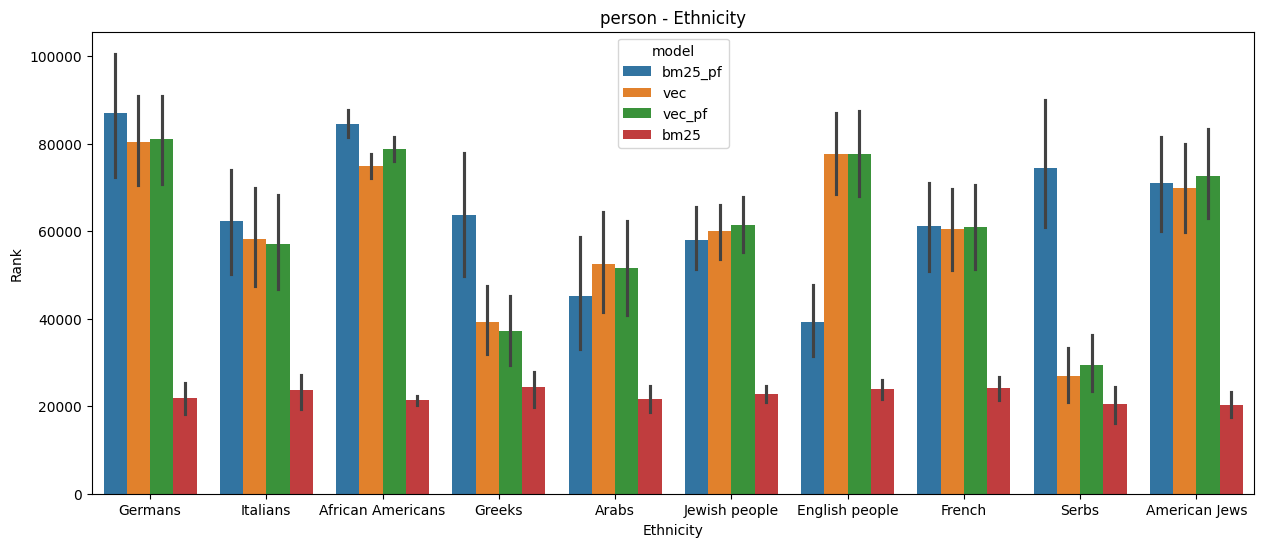

C:\Users\19441\AppData\Local\Temp\ipykernel_6848\2565259387.py:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(x=attribute, y='rank', hue='model', data=temp_df, ci=95)


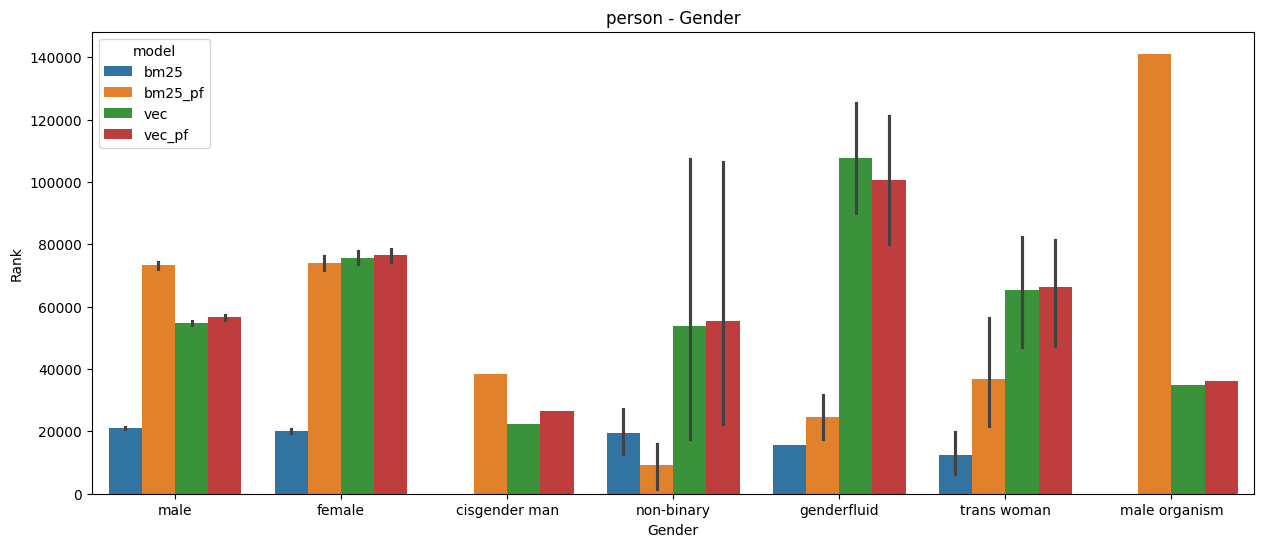

C:\Users\19441\AppData\Local\Temp\ipykernel_6848\2565259387.py:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(x=attribute, y='rank', hue='model', data=temp_df, ci=95)


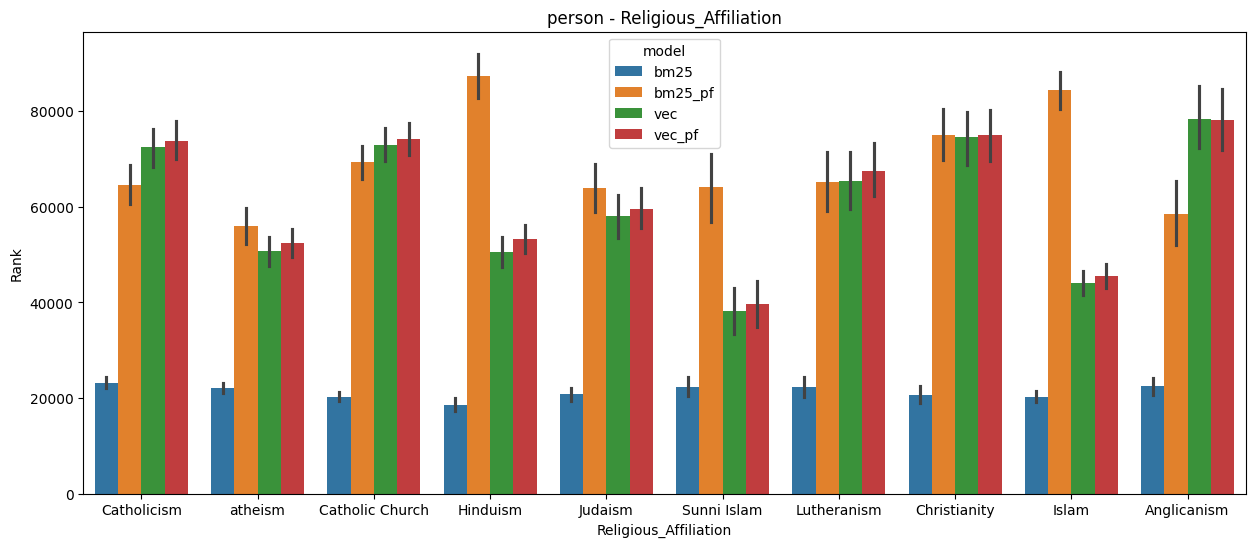

C:\Users\19441\AppData\Local\Temp\ipykernel_6848\2565259387.py:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(x=attribute, y='rank', hue='model', data=temp_df, ci=95)


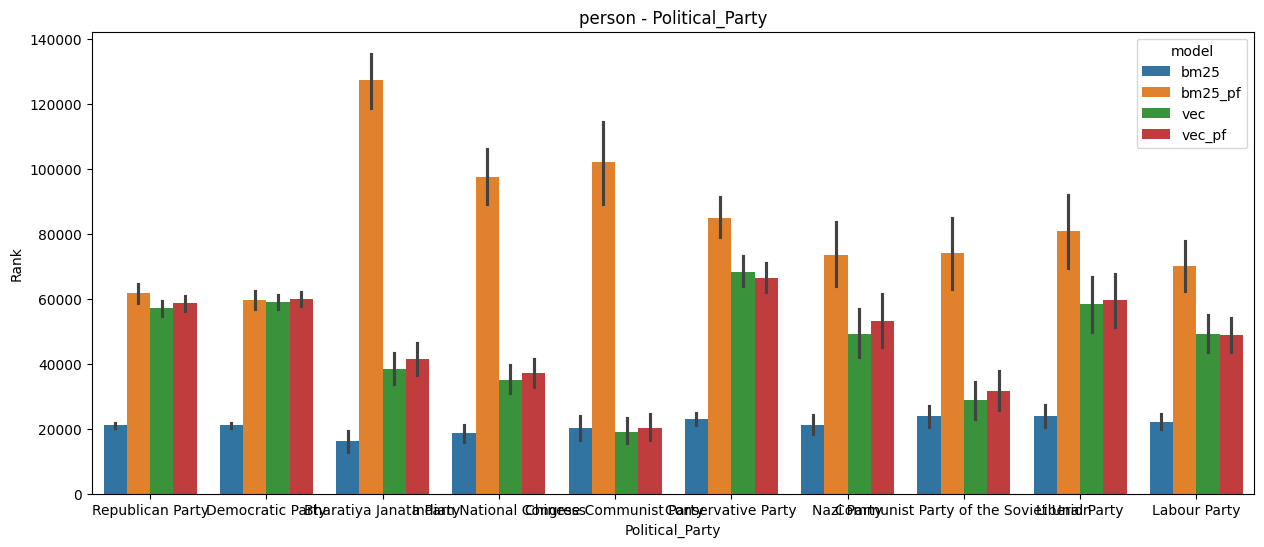

C:\Users\19441\AppData\Local\Temp\ipykernel_6848\2565259387.py:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(x=attribute, y='rank', hue='model', data=temp_df, ci=95)


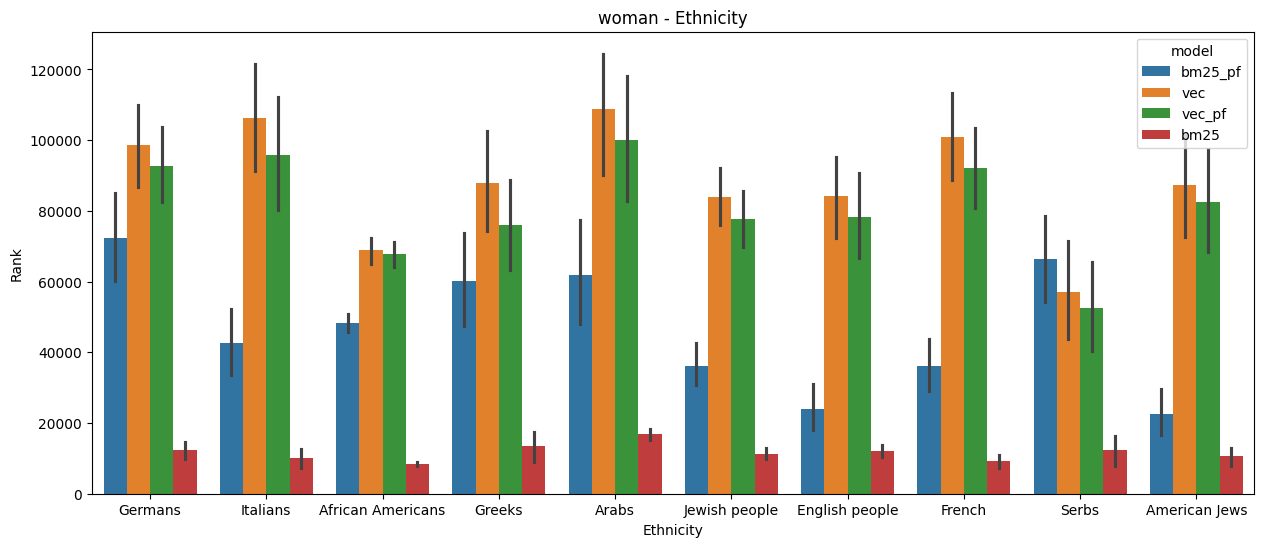

C:\Users\19441\AppData\Local\Temp\ipykernel_6848\2565259387.py:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(x=attribute, y='rank', hue='model', data=temp_df, ci=95)


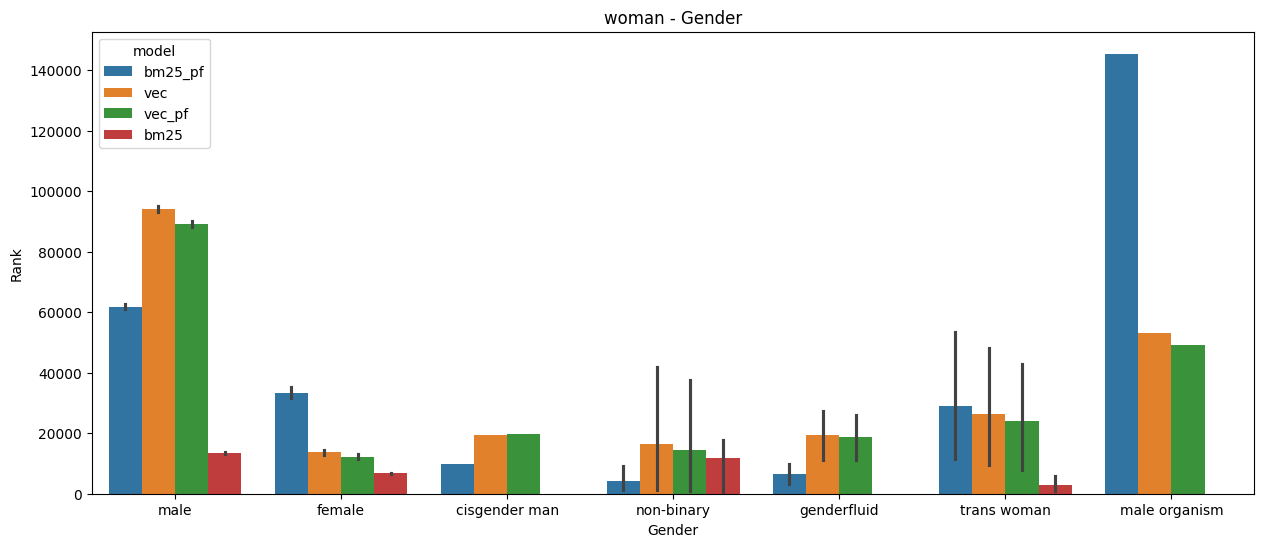

C:\Users\19441\AppData\Local\Temp\ipykernel_6848\2565259387.py:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(x=attribute, y='rank', hue='model', data=temp_df, ci=95)


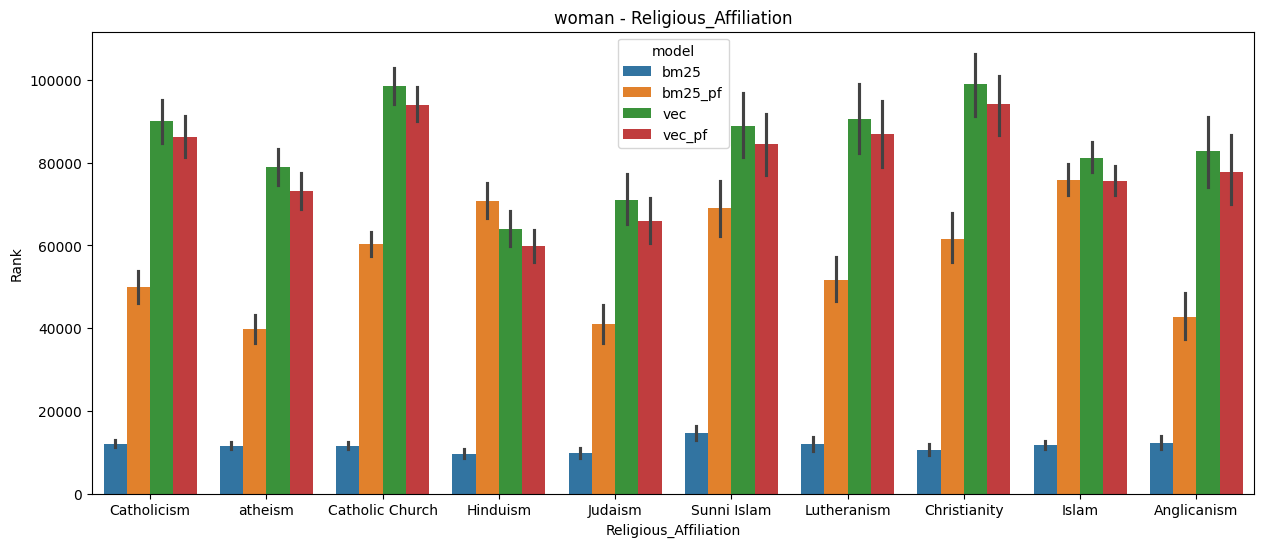

C:\Users\19441\AppData\Local\Temp\ipykernel_6848\2565259387.py:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(x=attribute, y='rank', hue='model', data=temp_df, ci=95)


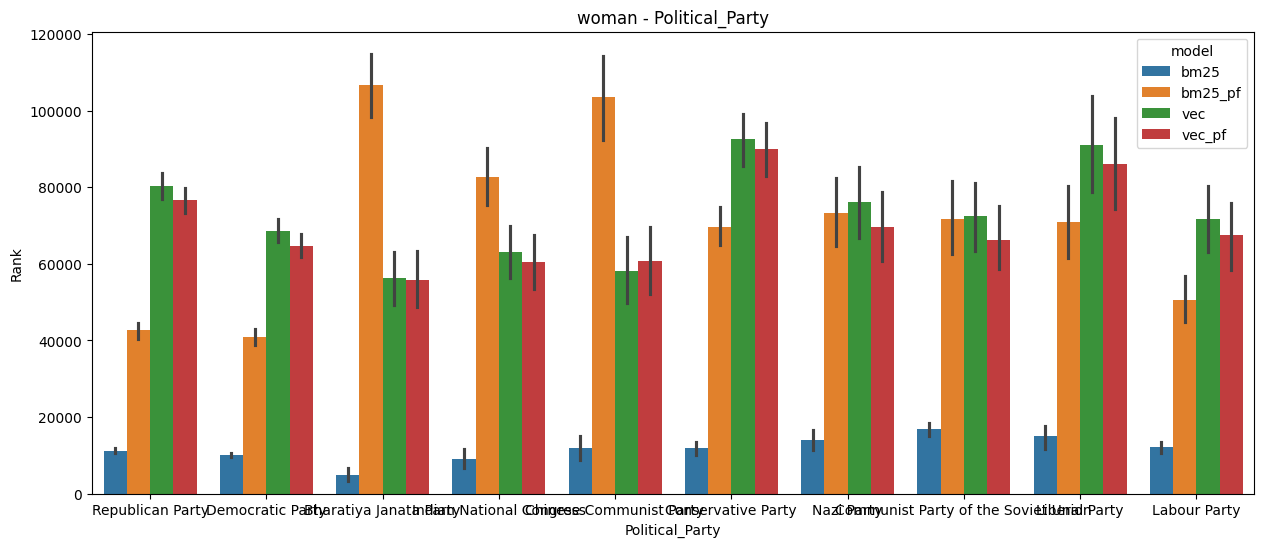

C:\Users\19441\AppData\Local\Temp\ipykernel_6848\2565259387.py:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(x=attribute, y='rank', hue='model', data=temp_df, ci=95)


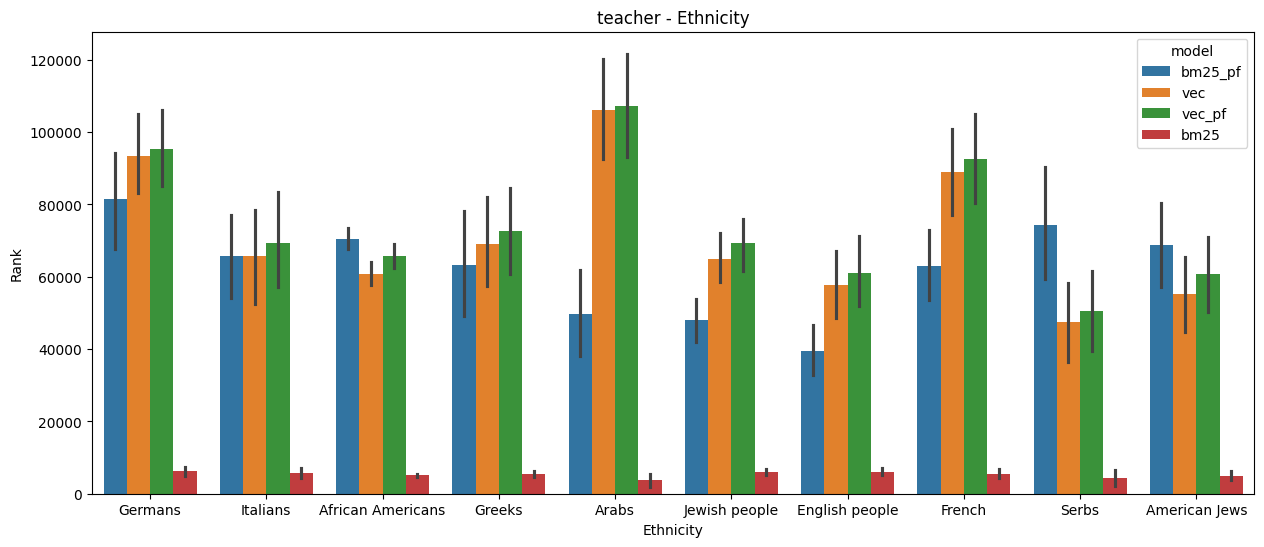

C:\Users\19441\AppData\Local\Temp\ipykernel_6848\2565259387.py:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(x=attribute, y='rank', hue='model', data=temp_df, ci=95)


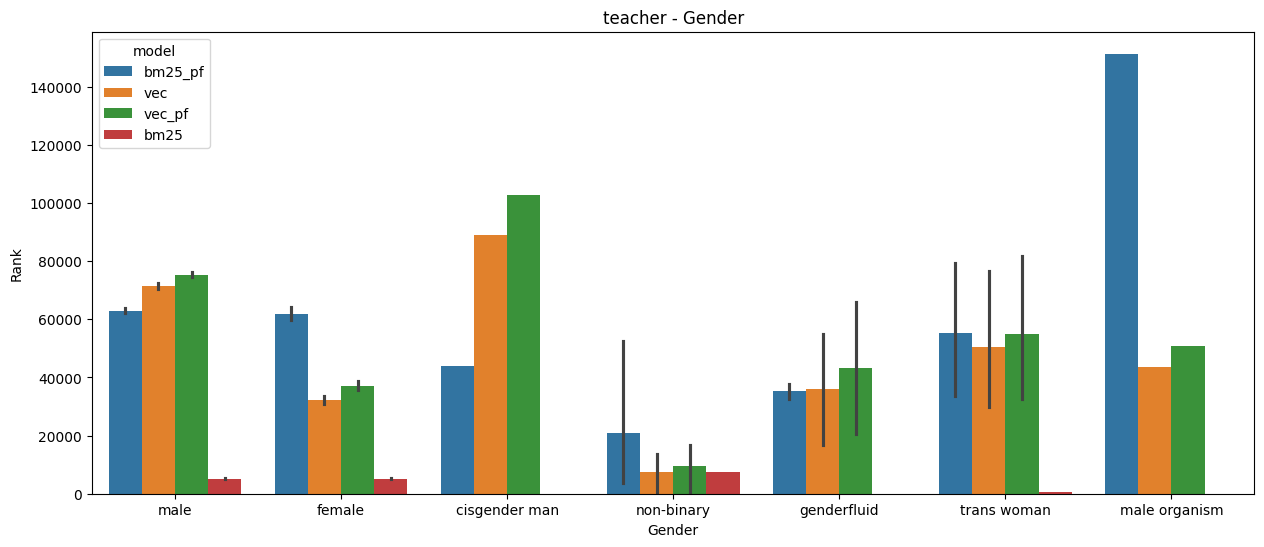

C:\Users\19441\AppData\Local\Temp\ipykernel_6848\2565259387.py:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(x=attribute, y='rank', hue='model', data=temp_df, ci=95)


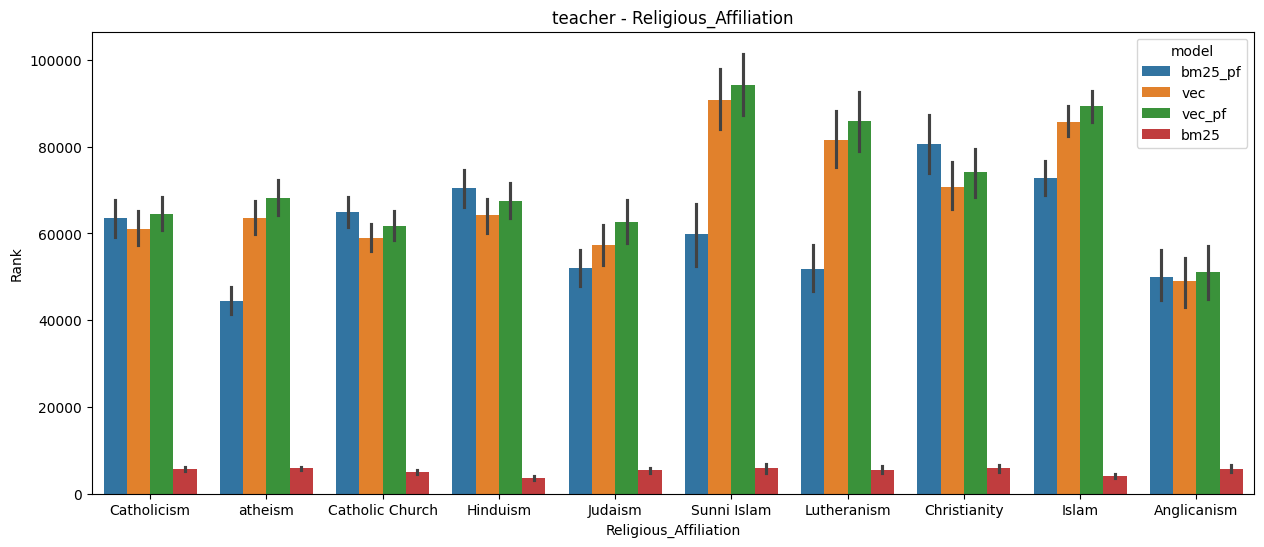

C:\Users\19441\AppData\Local\Temp\ipykernel_6848\2565259387.py:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(x=attribute, y='rank', hue='model', data=temp_df, ci=95)


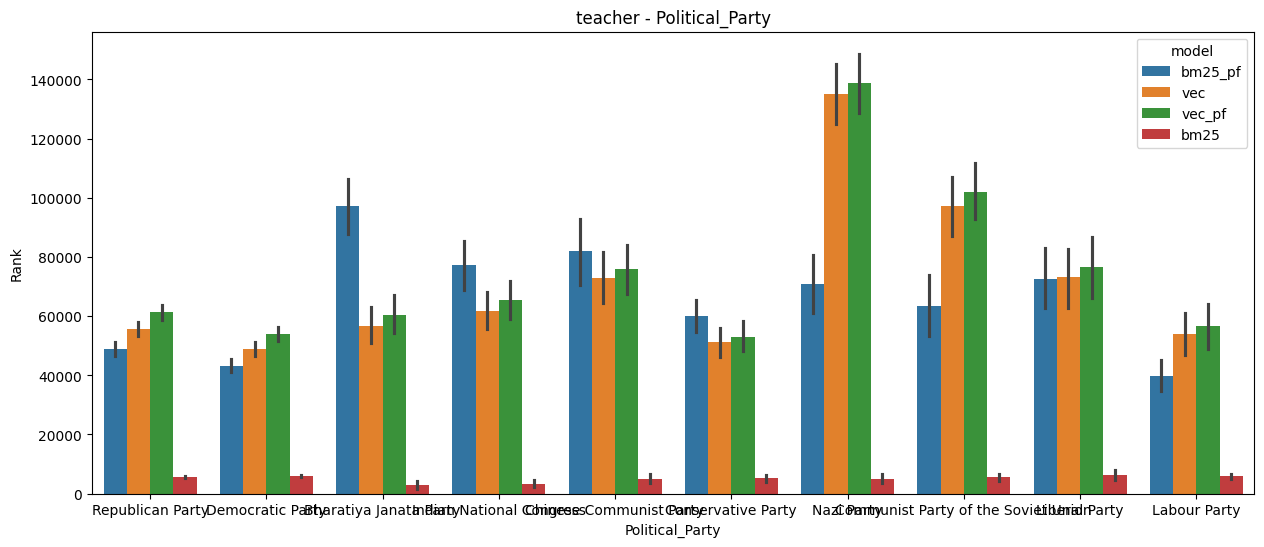

C:\Users\19441\AppData\Local\Temp\ipykernel_6848\2565259387.py:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(x=attribute, y='rank', hue='model', data=temp_df, ci=95)


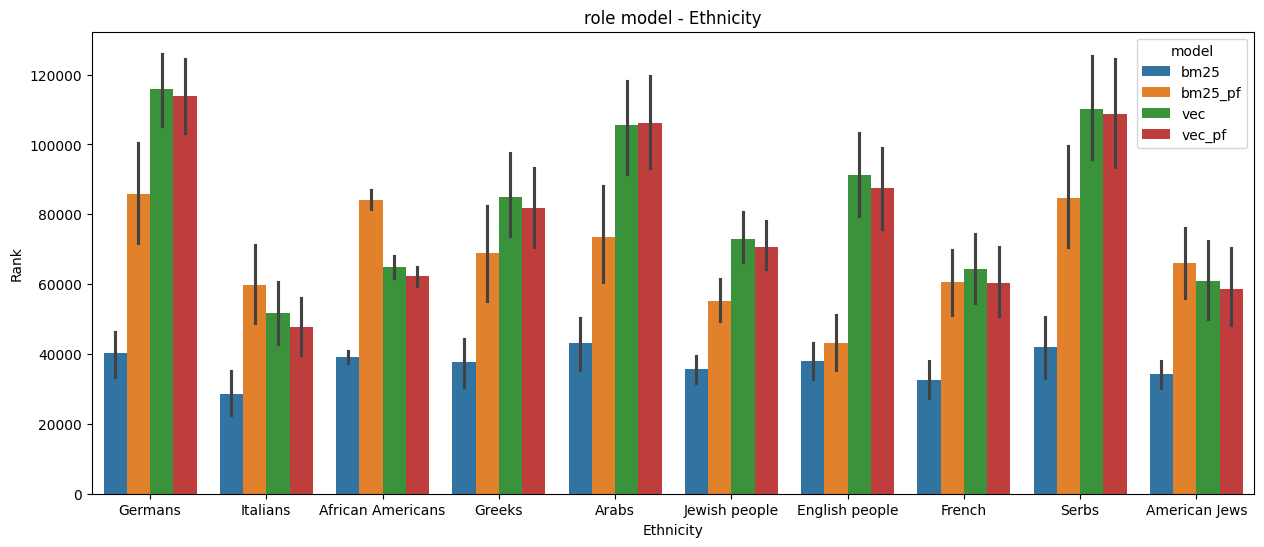

C:\Users\19441\AppData\Local\Temp\ipykernel_6848\2565259387.py:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(x=attribute, y='rank', hue='model', data=temp_df, ci=95)


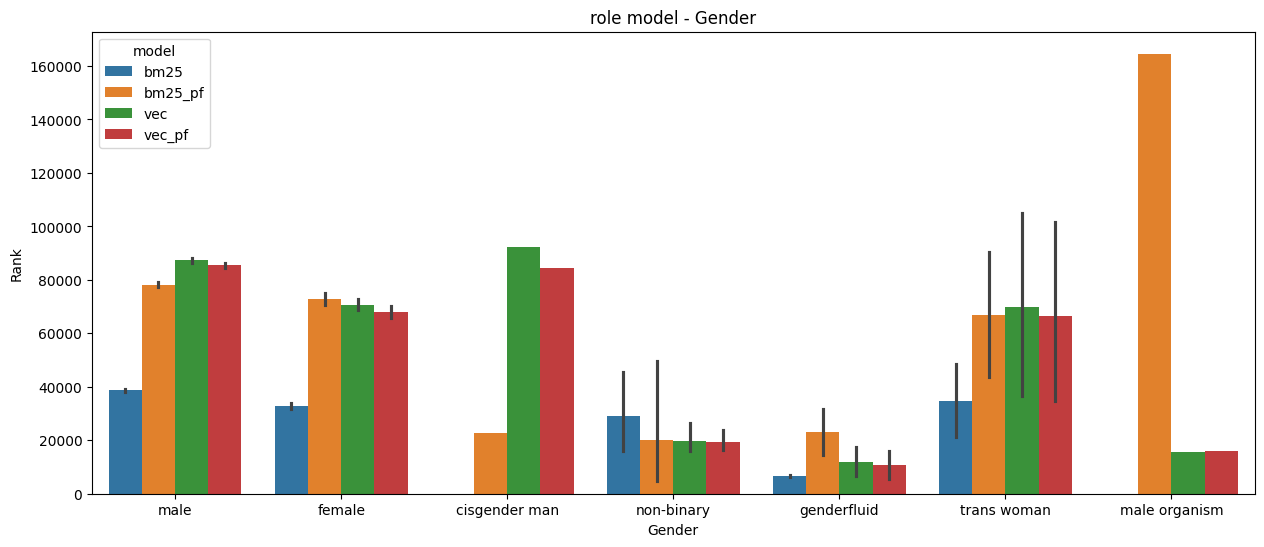

C:\Users\19441\AppData\Local\Temp\ipykernel_6848\2565259387.py:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(x=attribute, y='rank', hue='model', data=temp_df, ci=95)


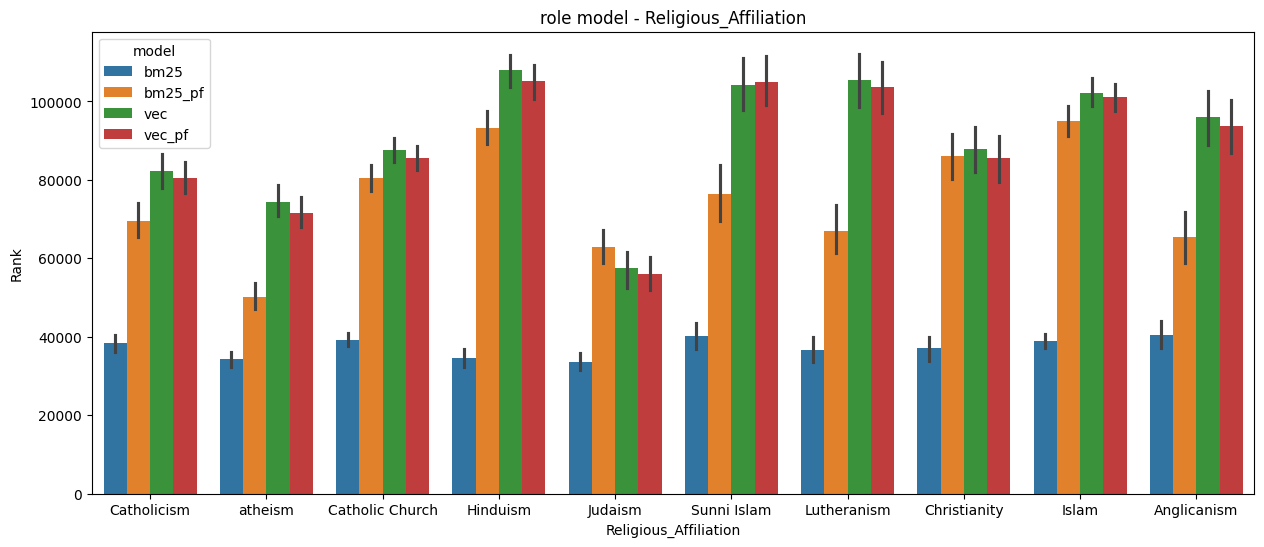

C:\Users\19441\AppData\Local\Temp\ipykernel_6848\2565259387.py:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(x=attribute, y='rank', hue='model', data=temp_df, ci=95)


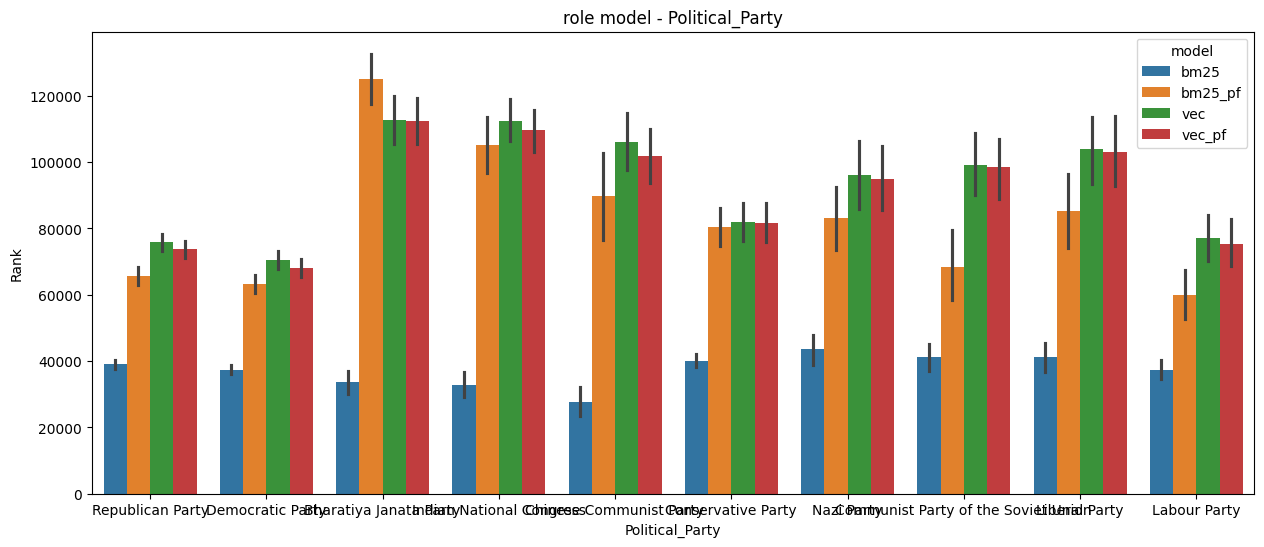

C:\Users\19441\AppData\Local\Temp\ipykernel_6848\2565259387.py:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(x=attribute, y='rank', hue='model', data=temp_df, ci=95)


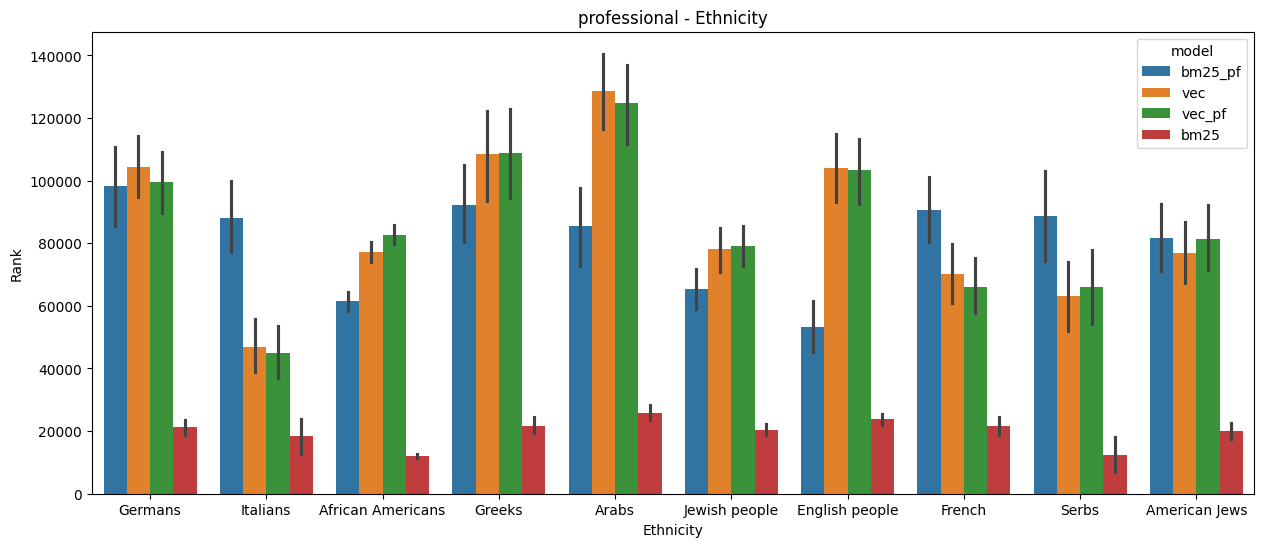

C:\Users\19441\AppData\Local\Temp\ipykernel_6848\2565259387.py:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(x=attribute, y='rank', hue='model', data=temp_df, ci=95)


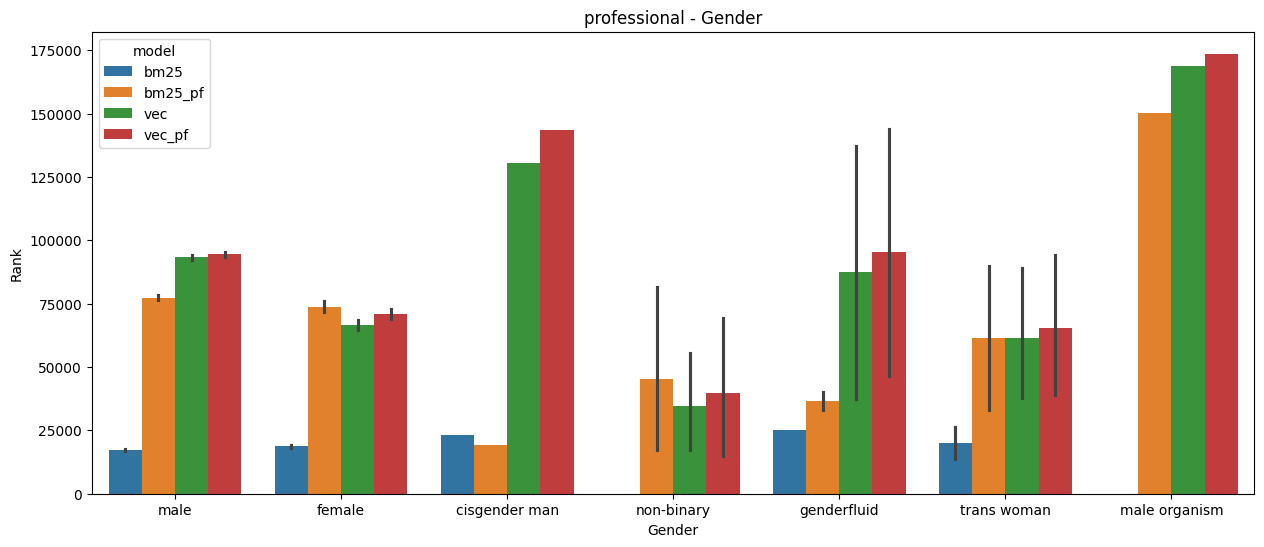

C:\Users\19441\AppData\Local\Temp\ipykernel_6848\2565259387.py:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(x=attribute, y='rank', hue='model', data=temp_df, ci=95)


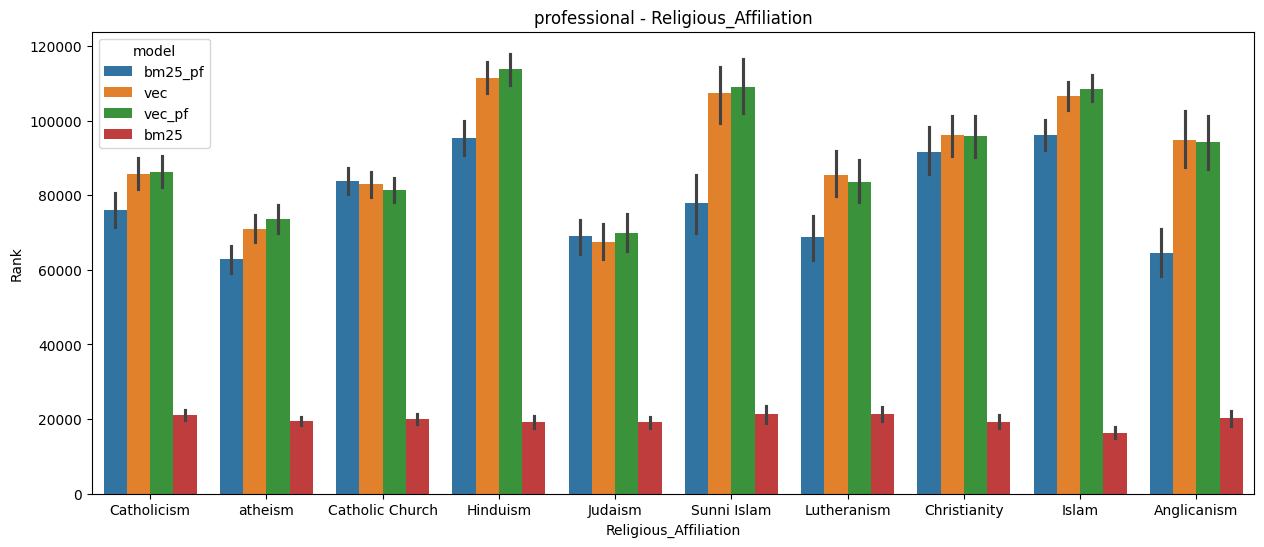

C:\Users\19441\AppData\Local\Temp\ipykernel_6848\2565259387.py:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(x=attribute, y='rank', hue='model', data=temp_df, ci=95)


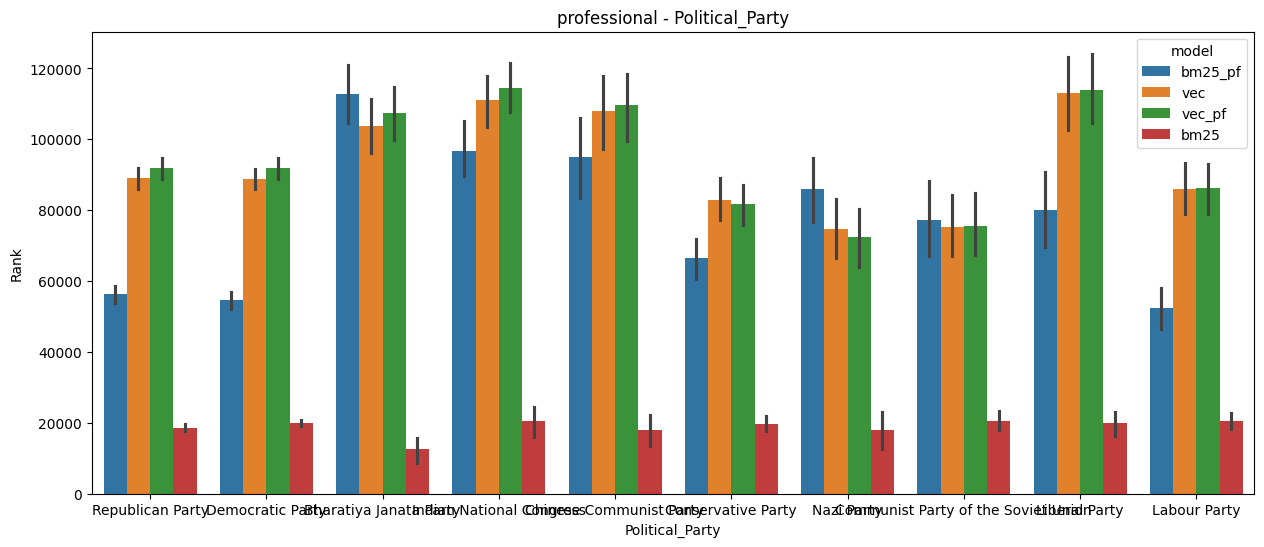

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

personal_df = pd.read_csv('person-attributes.csv', encoding='ISO-8859-1')
merged_df = pd.merge(personal_df, doc_200k_ranks_df, on='docid', how='left')
queries = ["person", "woman", "teacher", "role model", "professional"]
attributes = ['Ethnicity', 'Gender', 'Religious_Affiliation', 'Political_Party']
for query in queries:
    for attribute in attributes:
        categories = attribute_common_df[attribute]
        categories = categories[categories.notnull()].to_list()
        temp_df = merged_df[(merged_df['query'] == query) & (merged_df[attribute].isin(categories))]
        plt.figure(figsize=(15, 6))
        sns.barplot(x=attribute, y='rank', hue='model', data=temp_df, ci=95)
        plt.xlabel(attribute)
        plt.ylabel('Rank')
        plt.title(f'{query} - {attribute}')
        plt.show()

## Problem 2

In [5]:
from network_features import NetworkFeatures
import pandas as pd
import json

network = NetworkFeatures()
g = network.load_network('edgelist.csv.gz', 92650947)
node_names = list(g.names)

In [6]:
from network_features import NetworkFeatures
import pandas as pd
import json
import numpy as np


personal_seed_path = 'personalization.jsonl'

user_seeds_mp = {}
with open(personal_seed_path, 'r') as f:
    for line in f:
        temp = json.loads(line)
        user_docids = set([doc['docid'] for doc in temp['seed_docs']])
        weights = [0]*len(node_names)
        for i, node in enumerate(node_names):
            if node in user_docids:
                weights[i] = 1
        weights = np.array(weights)
        weights = weights/np.sum(weights)
        user_seeds_mp[temp['user_id']] = list(weights)

from network_features import NetworkFeatures

wiki_200k_path = 'wikipedia_200k_dataset.jsonl'
docid_title_mp = {}
with open(wiki_200k_path, 'r') as f:
    for line in f:
        doc = json.loads(line)
        docid_title_mp[int(doc['docid'])] = doc['title']


for user_id, seed_mp in user_seeds_mp.items():
    pageranks = network.calculate_page_rank(graph=g, weights=seed_mp)
    df = pd.DataFrame(g.names, columns=['docid'])
    df['pagerank'] = pageranks
    df['title'] = df['docid'].map(docid_title_mp)
    df = df.sort_values('pagerank', ascending=False)
    print(f'User {user_id} top 10 docs:')
    display(df.head(20))

User 1 top 10 docs:


,docid,pagerank,title
969,6021,0.015636,C (programming language)
714485,27471338,0.014866,Object-oriented programming
12895,93817,0.014449,Data type
1194,7392,0.014289,Class (computer programming)
883394,46561507,0.014007,Visual Studio Code
29639,273993,0.013992,Stack (abstract data type)
621552,18933234,0.013913,Emacs
39460,324378,0.013891,C standard library
465468,7933386,0.013759,CUDA
255286,2356314,0.013757,Open-source software development


User 2 top 10 docs:


,docid,pagerank,title
81893,567471,0.012816,Sea otter
581123,15295535,0.012759,Snow leopard
272993,2607068,0.012741,Giant otter
5372,32587,0.012608,Veganism
7186,48664,0.012604,Yosemite National Park
7336,49725,0.012601,American bison
866277,44035599,0.012583,Deforestation and climate change
634237,20041526,0.012583,Overpopulation
68474,477917,0.012580,Lemur
75535,523133,0.012574,Zookeeper


## Problem 3

In [1]:
from network_features import NetworkFeatures
import pandas as pd
import json

ntw = NetworkFeatures()
graph = ntw.load_network('edgelist.csv.gz',92650947)

d:\Anaconda3\envs\si650\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
import numpy as np

personal_seed_path = 'personalization.jsonl'
node_names = list(graph.names)
user_seeds_mp = {}
with open(personal_seed_path, 'r') as f:
    for line in f:
        temp = json.loads(line)
        user_docids = set([doc['docid'] for doc in temp['seed_docs']])
        weights = [0]*len(node_names)
        for i, node in enumerate(node_names):
            if node in user_docids:
                weights[i] = 1
        weights = np.array(weights)
        weights = weights/np.sum(weights)
        user_seeds_mp[temp['user_id']] = list(weights)

for user_id, seed_mp in user_seeds_mp.items():
    df = ntw.get_all_network_statistics(graph, seed_mp)
    df.to_csv('user_file/network_stats_user_'+str(user_id)+'.csv', index=False)

In [2]:
import pandas as pd
from indexing import BasicInvertedIndex
import seaborn as sns
import matplotlib.pyplot as plt
import json
import numpy as np
import tqdm
from l2r import L2RFeatureExtractor, L2RRanker
from document_preprocessor import RegexTokenizer
from ranker import BM25, TF_IDF
import gc
from vector_ranker import VectorRanker
from ranker import CrossEncoderScorer
from sentence_transformers import SentenceTransformer, CrossEncoder
import torch
import time
from relevance import run_relevance_tests
from torch.nn.functional import softmax

wiki_path = 'wikipedia_200k_dataset.jsonl'
wiki_title_dir = 'freq_50_cache_title'
wiki_text_dir = 'freq_50_cache'
stop_words_path = 'stopwords.txt'
category_set_path = 'category_set.txt'
doc_category_info_path = 'doc_category_dict.json'
user1_doc_network_path = 'user_file/network_stats_user_1.csv'
user2_doc_network_path = 'user_file/network_stats_user_2.csv'

temp = json.load(open(doc_category_info_path))
doc_category_info = {}
for key in temp:
    doc_category_info[int(key)] = temp[key]
del temp
gc.collect()

category_set = set()
with open(category_set_path, 'r') as f:
    lines = f.readlines()
    for line in lines:
        category_set.add(line.strip())

stop_words = set()
with open(stop_words_path, 'r', encoding='utf-8') as f:
    lines = f.readlines()
    for line in lines:
        stop_words.add(line.strip())

docid_to_network_features_user1 = {}
df = pd.read_csv(user1_doc_network_path)
for row in df.itertuples():
    docid_to_network_features_user1[row.docid] = {'pagerank': row.pagerank, 'authority_score': row.authority_score, 'hub_score': row.hub_score}
docid_to_network_features_user2 = {}
df = pd.read_csv(user2_doc_network_path)
for row in df.itertuples():
    docid_to_network_features_user2[row.docid] = {'pagerank': row.pagerank, 'authority_score': row.authority_score, 'hub_score': row.hub_score}
      

title_index = BasicInvertedIndex()
title_index.load(wiki_title_dir)
doc_index = BasicInvertedIndex()
doc_index.load(wiki_text_dir)

embedding = np.load('wiki-200k-vecs.msmarco-MiniLM-L12-cos-v5.npy')
docid_path = 'document-ids.txt'
docid_list = []
with open(docid_path, 'r') as f:
    for line in f:
        docid_list.append(int(line.strip()))
vector_ranker = VectorRanker('sentence-transformers/msmarco-MiniLM-L12-cos-v5', embedding, docid_list)

docid_text_map = {}
with open(wiki_path, 'r') as f:
    for line in f:
        doc = json.loads(line)
        docid_text_map[int(doc['docid'])] = ' '.join(doc['text'].split(' ')[:500])
ce_scorer = CrossEncoderScorer(docid_text_map, 'cross-encoder/msmarco-MiniLM-L6-en-de-v1')

d:\Anaconda3\envs\si650\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded!
Loaded!


In [7]:
import l2r
import importlib
importlib.reload(l2r)
from l2r import L2RFeatureExtractor, L2RRanker

doc_network_path = 'full_network_stats.csv'
docid_to_network_features = {}
df = pd.read_csv(doc_network_path)
for row in df.itertuples():
    docid_to_network_features[row.docid] = {'pagerank': row.pagerank, 'authority_score': row.authority_score, 'hub_score': row.hub_score}

l2r_feature_extractor = L2RFeatureExtractor(document_index=doc_index, title_index=title_index, 
                                            doc_category_info=doc_category_info, document_preprocessor=RegexTokenizer('\w+'),
                                            stopwords=stop_words, recognized_categories = category_set,
                                            docid_to_network_features=docid_to_network_features,
                                            ce_scorer=ce_scorer)
l2r_ranker = L2RRanker(document_index=doc_index, title_index=title_index, document_preprocessor=RegexTokenizer('\w+'),
                       stopwords=stop_words, ranker=vector_ranker,
                       feature_extractor=l2r_feature_extractor)


In [8]:
l2r_ranker.train('training_data/hw2_relevance.train.csv')

Preparing training data
Training data prepared
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005791 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2905
[LightGBM] [Info] Number of data points in the train set: 11916, number of used features: 128


In [9]:
import pandas as pd
import numpy as np

querys = ["python", "java", "bug"]
user_query_doc_mp = {}
l2r_feature_extractor_user1 = L2RFeatureExtractor(document_index=doc_index, title_index=title_index,
                                                    doc_category_info=doc_category_info, document_preprocessor=RegexTokenizer('\w+'),
                                                    stopwords=stop_words, recognized_categories = category_set,
                                                    docid_to_network_features=docid_to_network_features_user1,
                                                    ce_scorer=ce_scorer)
l2r_feature_extractor_user2 = L2RFeatureExtractor(document_index=doc_index, title_index=title_index,
                                                    doc_category_info=doc_category_info, document_preprocessor=RegexTokenizer('\w+'),
                                                    stopwords=stop_words, recognized_categories = category_set,
                                                    docid_to_network_features=docid_to_network_features_user2,
                                                    ce_scorer=ce_scorer)
for query in querys:
    l2r_ranker.feature_extractor = l2r_feature_extractor_user1
    user1_docs = l2r_ranker.query(query)[:10]
    user_query_doc_mp['user1_'+query] = [doc[0] for doc in user1_docs]
    l2r_ranker.feature_extractor = l2r_feature_extractor_user2
    user2_docs = l2r_ranker.query(query)[:10]
    user_query_doc_mp['user2_'+query] = [doc[0] for doc in user2_docs]

user_query_doc_df = pd.DataFrame(user_query_doc_mp)

In [11]:
wiki_200k_path = 'wikipedia_200k_dataset.jsonl'
docid_title_mp = {}
with open(wiki_200k_path, 'r') as f:
    for line in f:
        doc = json.loads(line)
        docid_title_mp[int(doc['docid'])] = doc['title']

for query in querys:
    user_query_doc_df['user1_'+query] = user_query_doc_df['user1_'+query].map(docid_title_mp)
    user_query_doc_df['user2_'+query] = user_query_doc_df['user2_'+query].map(docid_title_mp)

user_query_doc_df

,user1_python,user2_python,user1_java,user2_java,user1_bug,user2_bug
0,Monty Python,Monty Python,Java (software platform),Java (software platform),Debugging,Debugging
1,Python License,Python License,Free Java implementations,Java Card,Score bug,Score bug
2,Python Software Foundation License,Python Software Foundation License,Java bytecode,Free Java implementations,AEA June Bug,Baja Bug
3,Mod python,Mod python,Jakarta EE,Java bytecode,Bug zapper,AEA June Bug
4,Flask (web framework),Flask (web framework),"Write once, run anywhere",Jakarta EE,Bug tracking system,Bug zapper
5,Django (web framework),Django (web framework),Java Development Kit,"Write once, run anywhere",A Bug's Life (soundtrack),Southern Bug
6,Web Server Gateway Interface,Web Server Gateway Interface,Java Card,Java Development Kit,Southern Bug,Bug tracking system
7,Monty Python's Flying Circus,Monty Python's Flying Circus,Java Desktop System,Java Desktop System,Software bug,A Bug's Life (soundtrack)
8,Python (programming language),Python (programming language),Visual J Sharp,Visual J Sharp,Baja Bug,Pentatomidae
9,PyPy,PyPy,Ontong Java language,Ontong Java language,Pentatomidae,Software bug


## Problem 4

In [1]:
import json

with open('personalization.jsonl', 'r') as f:
    for line in f:
        temp = json.loads(line)
        user_id = temp['user_id']
        with open(f'user_file/user_{user_id}.jsonl', 'w') as f2:
            for doc in temp['seed_docs']:
                f2.write(json.dumps(doc)+'\n')

In [1]:
from enum import Enum
from document_preprocessor import Tokenizer, SplitTokenizer, RegexTokenizer, SpaCyTokenizer
from collections import Counter, defaultdict
import json
import os
from indexing import Indexer, IndexType
from ranker import BM25, Ranker, PersonalizedBM25
import pandas as pd
import numpy as np
from indexing import BasicInvertedIndex


wiki_text_dir = 'freq_50_cache'
doc_index = BasicInvertedIndex()
doc_index.load(wiki_text_dir)
stop_words_path = 'stopwords.txt'
stop_words = set()
with open(stop_words_path, 'r', encoding='utf-8') as f:
    lines = f.readlines()
    for line in lines:
        stop_words.add(line.strip())
bm25_scorer = BM25(doc_index)
bm25_ranker = Ranker(doc_index, RegexTokenizer('\w+'), stop_words, bm25_scorer)

user1_dir = 'user_file/user_1.jsonl'
user2_dir = 'user_file/user_2.jsonl'
user1_index = BasicInvertedIndex()

regex_tokenizer = RegexTokenizer(lowercase=True)
user1_index = Indexer.create_index(
    index_type=IndexType.BasicInvertedIndex,
    dataset_path=user1_dir,
    document_preprocessor=regex_tokenizer,
    stopwords=stop_words,
    minimum_word_frequency=-1,
    text_key='text',
    max_docs=-1
)
user2_index = Indexer.create_index(
    index_type=IndexType.BasicInvertedIndex,
    dataset_path=user2_dir,
    document_preprocessor=regex_tokenizer,
    stopwords=stop_words,
    minimum_word_frequency=-1,
    text_key='text',
    max_docs=-1
)

user1_scorer = PersonalizedBM25(doc_index, user1_index)
user1_ranker = Ranker(doc_index, RegexTokenizer('\w+'), stop_words, user1_scorer)
user2_scorer = PersonalizedBM25(doc_index, user2_index)
user2_ranker = Ranker(doc_index, RegexTokenizer('\w+'), stop_words, user2_scorer)


querys = ["python", "java", "bug"]
user_query_doc_mp = {}
for query in querys:
    original_docs = bm25_ranker.query(query)[:10]
    user_query_doc_mp['bm25'+query] = [doc[0] for doc in original_docs]
    user1_docs = user1_ranker.query(query)[:10]
    user_query_doc_mp['user1_'+query] = [doc[0] for doc in user1_docs]
    user2_docs = user2_ranker.query(query)[:10]
    user_query_doc_mp['user2_'+query] = [doc[0] for doc in user2_docs]

user_query_doc_df = pd.DataFrame(user_query_doc_mp)

d:\Anaconda3\envs\si650\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded!


Indexing documents: 100%|██████████| 13/13 [00:00<00:00, 224.75it/s]


In [2]:
user_query_doc_df 

,bm25python,user1_python,user2_python,bm25java,user1_java,user2_java,bm25bug,user1_bug,user2_bug
0,23862,23862,23862,4718446,4718446,4718446,898290,898290,898290
1,1984246,1984246,1984246,2070564,2070564,2070564,1012051,1012051,1012051
2,18942,18942,18942,7771171,7771171,7771171,37085,37085,37085
3,23329,23329,23329,15881,15881,15881,2047790,2047790,2047790
4,5087621,5087621,5087621,69336,69336,69336,395188,395188,395188
5,390263,390263,390263,320443,320443,320443,605702,605702,605702
6,29040606,29040606,29040606,42871,42871,42871,1028992,1028992,1028992
7,2564605,2564605,2564605,12540957,12540957,12540957,952459,952459,952459
8,819149,819149,819149,38321273,38321273,38321273,3351638,3351638,3351638
9,381782,381782,381782,453584,453584,453584,802481,802481,802481


In [5]:
wiki_200k_path = 'wikipedia_200k_dataset.jsonl'
docid_title_mp = {}
with open(wiki_200k_path, 'r') as f:
    for line in f:
        doc = json.loads(line)
        docid_title_mp[int(doc['docid'])] = doc['title']

for query in querys:
    user_query_doc_df['bm25'+query] = user_query_doc_df['bm25'+query].map(docid_title_mp)
    user_query_doc_df['user1_'+query] = user_query_doc_df['user1_'+query].map(docid_title_mp)
    user_query_doc_df['user2_'+query] = user_query_doc_df['user2_'+query].map(docid_title_mp)

user_query_doc_df

,bm25python,user1_python,user2_python,bm25java,user1_java,user2_java,bm25bug,user1_bug,user2_bug
0,Python (programming language),Python (programming language),Python (programming language),Java (software platform),Java (software platform),Java (software platform),Bug tracking system,Bug tracking system,Bug tracking system
1,CPython,CPython,CPython,Java Card,Java Card,Java Card,Ambush Bug,Ambush Bug,Ambush Bug
2,Monty Python,Monty Python,Monty Python,Java version history,Java version history,Java version history,Software bug,Software bug,Software bug
3,Pythonidae,Pythonidae,Pythonidae,Java (programming language),Java (programming language),Java (programming language),Bug zapper,Bug zapper,Bug zapper
4,Python License,Python License,Python License,Java,Java,Java,Narew,Narew,Narew
5,Jython,Jython,Jython,East Java,East Java,East Java,Southern Bug,Southern Bug,Southern Bug
6,Flask (web framework),Flask (web framework),Flask (web framework),"Java Platform, Standard Edition","Java Platform, Standard Edition","Java Platform, Standard Edition",AEA June Bug,AEA June Bug,AEA June Bug
7,PyPy,PyPy,PyPy,Java mouse-deer,Java mouse-deer,Java mouse-deer,Bed bug,Bed bug,Bed bug
8,Burmese python,Burmese python,Burmese python,Java bytecode,Java bytecode,Java bytecode,Score bug,Score bug,Score bug
9,NumPy,NumPy,NumPy,Central Java,Central Java,Central Java,Baja Bug,Baja Bug,Baja Bug


## Problem 5

In [1]:
import pandas as pd
from indexing import BasicInvertedIndex
import seaborn as sns
import matplotlib.pyplot as plt
import json
import numpy as np
import tqdm
from l2r import L2RFeatureExtractor, L2RRanker
from document_preprocessor import RegexTokenizer
from ranker import BM25, TF_IDF
import gc
from vector_ranker import VectorRanker
from ranker import CrossEncoderScorer
from sentence_transformers import SentenceTransformer, CrossEncoder
import torch
import time
from relevance import run_relevance_tests
from torch.nn.functional import softmax

wiki_path = 'wikipedia_200k_dataset.jsonl'
wiki_title_dir = 'freq_50_cache_title'
wiki_text_dir = 'freq_50_cache'
stop_words_path = 'stopwords.txt'
category_set_path = 'category_set.txt'
doc_category_info_path = 'doc_category_dict.json'
doc_network_path = 'full_network_stats.csv'

temp = json.load(open(doc_category_info_path))
doc_category_info = {}
for key in temp:
    doc_category_info[int(key)] = temp[key]
del temp
gc.collect()

category_set = set()
with open(category_set_path, 'r') as f:
    lines = f.readlines()
    for line in lines:
        category_set.add(line.strip())

stop_words = set()
with open(stop_words_path, 'r', encoding='utf-8') as f:
    lines = f.readlines()
    for line in lines:
        stop_words.add(line.strip())

docid_to_network_features = {}
df = pd.read_csv(doc_network_path)
for row in df.itertuples():
    docid_to_network_features[row.docid] = {'pagerank': row.pagerank, 'authority_score': row.authority_score, 'hub_score': row.hub_score}
      

title_index = BasicInvertedIndex()
title_index.load(wiki_title_dir)
doc_index = BasicInvertedIndex()
doc_index.load(wiki_text_dir)

embedding = np.load('wiki-200k-vecs.msmarco-MiniLM-L12-cos-v5.npy')
docid_path = 'document-ids.txt'
docid_list = []
with open(docid_path, 'r') as f:
    for line in f:
        docid_list.append(int(line.strip()))
vector_ranker = VectorRanker('sentence-transformers/msmarco-MiniLM-L12-cos-v5', embedding, docid_list)

docid_text_map = {}
with open(wiki_path, 'r') as f:
    for line in f:
        doc = json.loads(line)
        docid_text_map[int(doc['docid'])] = ' '.join(doc['text'].split(' ')[:500])
ce_scorer = CrossEncoderScorer(docid_text_map, 'cross-encoder/msmarco-MiniLM-L6-en-de-v1')
ce_scorer = CrossEncoderScorer(docid_text_map, 'cross-encoder/msmarco-MiniLM-L6-en-de-v1')

d:\Anaconda3\envs\si650\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded!
Loaded!


In [2]:
import pandas as pd
from relevance import run_relevance_tests
from ranker import BM25, Ranker

bm25_scorer = BM25(doc_index)
bm25_ranker = Ranker(doc_index, RegexTokenizer('\w+'), stop_words, bm25_scorer)
bm25_result = run_relevance_tests('training_data/hw2_relevance.test.csv', bm25_ranker)
map_mp = {}
ndcg_mp = {}
map_mp['score'] = bm25_result['map_list']
map_mp['model'] = ['bm25']*len(bm25_result['map_list'])
ndcg_mp['score'] = bm25_result['ndcg_list']
ndcg_mp['model'] = ['bm25']*len(bm25_result['ndcg_list'])

100%|██████████| 53/53 [00:00<00:00, 1492.61it/s]


In [3]:
import l2r
import importlib
importlib.reload(l2r)
from l2r import L2RFeatureExtractor, L2RRanker

l2r_feature_extractor = L2RFeatureExtractor(document_index=doc_index, title_index=title_index, 
                                            doc_category_info=doc_category_info, document_preprocessor=RegexTokenizer('\w+'),
                                            stopwords=stop_words, recognized_categories = category_set,
                                            docid_to_network_features=docid_to_network_features,
                                            ce_scorer=ce_scorer)
hw2_l2r_ranker = L2RRanker(document_index=doc_index, title_index=title_index, document_preprocessor=RegexTokenizer('\w+'),
                       stopwords=stop_words, ranker=bm25_ranker,
                       feature_extractor=l2r_feature_extractor)


In [4]:
hw2_l2r_ranker.train('training_data/hw2_relevance.train.csv')

Preparing training data
Training data prepared
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005557 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2905
[LightGBM] [Info] Number of data points in the train set: 11916, number of used features: 128


In [5]:
result = run_relevance_tests('training_data/hw2_relevance.test.csv', ranker=hw2_l2r_ranker)
map_mp['score'] += result['map_list']
map_mp['model'] += ['l2r_hw2']*len(result['map_list'])
ndcg_mp['score'] += result['ndcg_list']
ndcg_mp['model'] += ['l2r_hw2']*len(result['ndcg_list'])

100%|██████████| 53/53 [00:00<00:00, 1341.55it/s]


In [6]:
hw3_l2r_ranker = L2RRanker(document_index=doc_index, title_index=title_index, document_preprocessor=RegexTokenizer('\w+'),
                       stopwords=stop_words, ranker=vector_ranker,
                       feature_extractor=l2r_feature_extractor)

In [7]:
hw3_l2r_ranker.train('training_data/hw2_relevance.train.csv')

Preparing training data
Training data prepared
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004609 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2905
[LightGBM] [Info] Number of data points in the train set: 11916, number of used features: 128


In [8]:
result = run_relevance_tests('training_data/hw2_relevance.test.csv', ranker=hw3_l2r_ranker)
map_mp['score'] += result['map_list']
map_mp['model'] += ['l2r_hw3']*len(result['map_list'])
ndcg_mp['score'] += result['ndcg_list']
ndcg_mp['model'] += ['l2r_hw3']*len(result['ndcg_list'])

100%|██████████| 53/53 [00:00<00:00, 941.76it/s]


In [9]:
argument_set = [
    (1, 0.9, 0.1),
    (1, 0.5, 0.5),
    (1, 0.1, 0.9),
    (5, 0.9, 0.1),
    (5, 0.5, 0.5),
    (5, 0.1, 0.9),
    (10, 0.9, 0.1),
    (10, 0.5, 0.5),
    (10, 0.1, 0.9)
]
for doc_num, a, b in argument_set:
    query_args = {
        'pseudofeedback_num_docs': doc_num,
        'pseudofeedback_alpha': a,
        'pseudofeedback_beta': b
    }
    result = run_relevance_tests('training_data/hw2_relevance.test.csv', ranker=hw3_l2r_ranker, ranker_args=query_args)
    map_mp['score'] += result['map_list']
    map_mp['model'] += [f'({doc_num},{a},{round(1-a, 1)})']*len(result['map_list'])
    ndcg_mp['score'] += result['ndcg_list']
    ndcg_mp['model'] += [f'({doc_num},{a},{round(1-a, 1)})']*len(result['ndcg_list'])


100%|██████████| 53/53 [00:00<00:00, 849.98it/s]


C:\Users\19441\AppData\Local\Temp\ipykernel_23084\3991014159.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(x='model', y='score', data=map_df, ci=95)


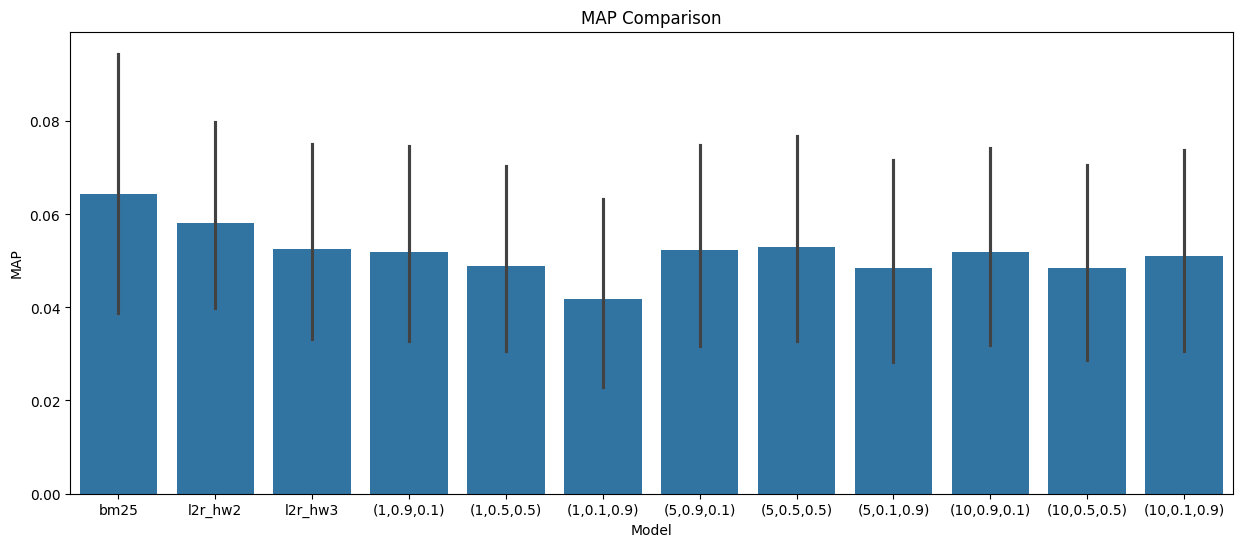

C:\Users\19441\AppData\Local\Temp\ipykernel_23084\3991014159.py:14: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(x='model', y='score', data=ndcg_df, ci=95)


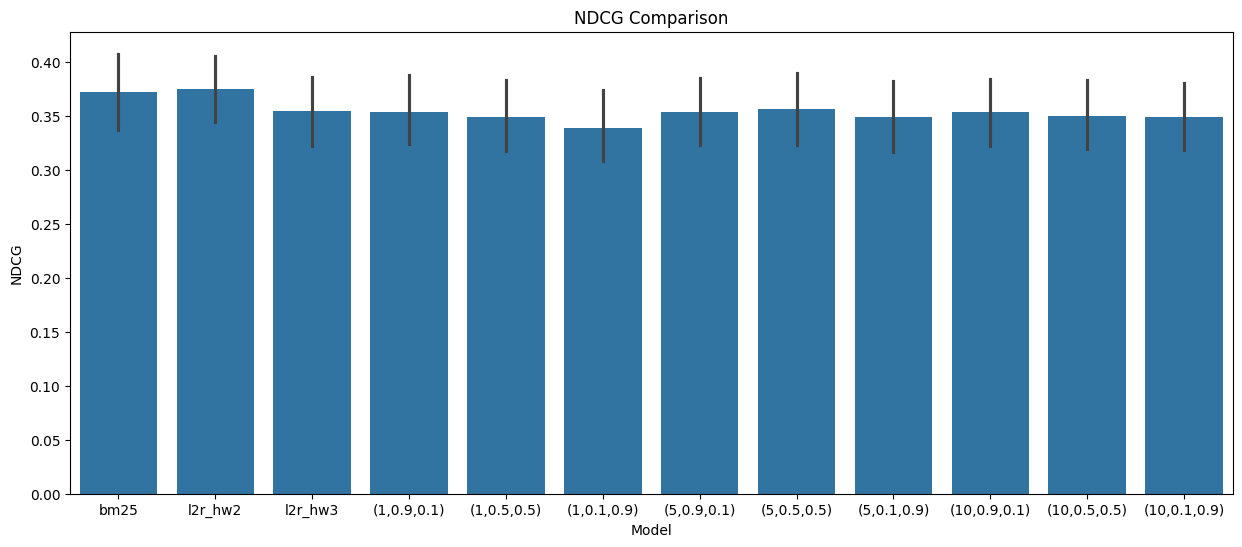

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

map_df = pd.DataFrame(map_mp)
ndcg_df = pd.DataFrame(ndcg_mp)

plt.figure(figsize=(15, 6))
sns.barplot(x='model', y='score', data=map_df, ci=95)
plt.xlabel('Model')
plt.ylabel('MAP')
plt.title('MAP Comparison')
plt.show()
plt.figure(figsize=(15, 6))
sns.barplot(x='model', y='score', data=ndcg_df, ci=95)
plt.xlabel('Model')
plt.ylabel('NDCG')
plt.title('NDCG Comparison')
plt.show()